<a href="https://colab.research.google.com/github/SKandar-1/Robinhood_Tweets_Sentiment/blob/main/Robinhood_Tweets_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [2]:
# Upload Twitter APT login file to google colab
from google.colab import files
uploaded = files.upload()

Saving login.csv to login.csv


In [3]:
# Store the data
log = pd.read_csv('login.csv')

In [4]:
# Get the twitter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [5]:
# Create the Authentication Object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)
# Set the access token and access token secret
authenticate.set_access_token(accessToken, accessTokenSecret)
# Create the API object
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [6]:
# Gather tweets about Robinhood and filter out any retweets 'RT'
search_term = '#Robinhood -filter:retweets'

In [7]:
# Create a cursor object
tweets = tweepy.Cursor(api.search, q=search_term, lang='en', since='2021-01-01', tweet_mode='extended').items(5000)

In [10]:
# Store the tweets in a variable
all_tweets = [tweet.full_text for tweet in tweets]

In [11]:
# Cerate a DataFrame to store the tweets in a column called 'Tweets'
Hood_df = pd.DataFrame(all_tweets, columns = ['Tweets'])
# Show the first six rows of DataFrame
Hood_df.head(6)

,Tweets
0,Robinhood Markets Inc is considering launching...
1,@nintcoin I'm proud to be in this Nintcoin com...
2,@nintcoin #Nint #RobinhoodIPO #Robinhood #Cryp...
3,#Robinhood's S-1 revealed that 17% of its Q1 r...
4,Robinhood : Kindly request of Robinhood to lis...
5,Origins of a Legend: Robin Hood. An article by...


In [12]:
# Save the DataFrame in a .csv file in Google Drive
Hood_df.to_csv('Hood_Twt_data_073021.csv')

In [13]:
from google.colab import drive
drive.mount('drive', force_remount=True)
!cp Hood_Twt_data_073021.csv "drive/My Drive/"

Mounted at drive


In [14]:
# DataFrame information
Hood_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tweets  554 non-null    object
dtypes: object(1)
memory usage: 4.5+ KB


In [15]:
# Check for null values
Hood_df.isnull().sum()

Tweets    0
dtype: int64

In [16]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
Test = '$I love AI & Machine learning=@\\!!'
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'I love AI  Machine learning'

In [18]:
Test = 'Good morning beautiful people :)... #I am having fun learning Finance with Python!!'

In [20]:
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'Good morning beautiful people  I am having fun learning Finance with Python'

In [21]:
# Define a function to remove punctuations
def remove_punc(message):
    Test_punc_removed = [char for char in message if char not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)

    return Test_punc_removed_join

In [22]:
# Remove punctuations from our dataset 
Hood_df['Tweets Without Punctuation'] = Hood_df['Tweets'].apply(remove_punc)

In [23]:
Hood_df

,Tweets,Tweets Without Punctuation
0,Robinhood Markets Inc is considering launching...,Robinhood Markets Inc is considering launching...
1,@nintcoin I'm proud to be in this Nintcoin com...,nintcoin Im proud to be in this Nintcoin compa...
2,@nintcoin #Nint #RobinhoodIPO #Robinhood #Cryp...,nintcoin Nint RobinhoodIPO Robinhood Crypto an...
3,#Robinhood's S-1 revealed that 17% of its Q1 r...,Robinhoods S1 revealed that 17 of its Q1 reven...
4,Robinhood : Kindly request of Robinhood to lis...,Robinhood Kindly request of Robinhood to list...
...,...,...
549,Proposal 2 needs to be approved for merger. #C...,Proposal 2 needs to be approved for merger CCI...
550,Transferred my stocks to #Webull they complete...,Transferred my stocks to Webull they completel...
551,NintCoin is an amazing project! with the amazi...,NintCoin is an amazing project with the amazin...
552,@nintcoin community is the most promising proj...,nintcoin community is the most promising proje...


In [24]:
Hood_df['Tweets'][2]

'@nintcoin #Nint #RobinhoodIPO #Robinhood #Crypto and #cryptocurrency\n\nVery good project with interesting and informative knowledge. Team behind the project is well experienced and hope it will go longer and proper their goals.Nice project.'

In [25]:
Hood_df['Tweets Without Punctuation'][2]

'nintcoin Nint RobinhoodIPO Robinhood Crypto and cryptocurrency\n\nVery good project with interesting and informative knowledge Team behind the project is well experienced and hope it will go longer and proper their goalsNice project'

In [26]:
# Download stopwords
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [27]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https', 'and'])
# stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])

In [28]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 3 and token not in stop_words:
            result.append(token)
            
    return result

In [29]:
# Apply pre-processing to the text column
Hood_df['Tweets Without Punc & Stopwords'] = Hood_df['Tweets Without Punctuation'].apply(preprocess)

In [30]:
Hood_df['Tweets'][0]

'Robinhood Markets Inc is considering launching U.S. retirement accounts, CEO and co-founder @vladtenev confirmed in a webcast\n\n #Robinhood #RobinhoodTraders #UnitedStates @RobinhoodApp \nhttps://t.co/lmsZVPpGeD'

In [31]:
Hood_df['Tweets Without Punc & Stopwords'][0]

['robinhood',
 'markets',
 'inc',
 'considering',
 'launching',
 'retirement',
 'accounts',
 'ceo',
 'cofounder',
 'vladtenev',
 'confirmed',
 'webcast',
 'robinhood',
 'unitedstates',
 'robinhoodapp']

In [ ]:
# join the words into a string
#Hood_df['Processed Text 2'] = Hood_df['Processed Text 2'].apply(lambda x: " ".join(x))

In [ ]:
Hood_df.head()

,Tweets,Tweets Without Punctuation,Tweets Without Punc & Stopwords
0,"This is why I wont be buying $HOOD, cuz they r...",This is why I wont be buying HOOD cuz they rob...,"[wont, buying, hood, cuz, robbed, gun, point, ..."
1,Let’s all short #Robinhood $HOOD,Let’s all short Robinhood HOOD,"[let, short, robinhood, hood]"
2,►► Get a #Free Stock and Watch It Grow - UNLIM...,►► Get a Free Stock and Watch It Grow UNLIMIT...,"[get, free, watch, grow, unlimited, potential,..."
3,Wonder if the shares bought will be routed to ...,Wonder if the shares bought will be routed to ...,"[wonder, shares, bought, routed, dark, pools, ..."
4,How funny would it be if the market top is on ...,How funny would it be if the market top is on ...,"[funny, would, market, top, robinhood, ipo, ho..."


In [32]:
# join the words into a string
Hood_df['Tweets Without Punc & Stopwords Joined'] = Hood_df['Tweets Without Punc & Stopwords'].apply(lambda x: " ".join(x))

In [33]:
Hood_df.head()

,Tweets,Tweets Without Punctuation,Tweets Without Punc & Stopwords,Tweets Without Punc & Stopwords Joined
0,Robinhood Markets Inc is considering launching...,Robinhood Markets Inc is considering launching...,"[robinhood, markets, inc, considering, launchi...",robinhood markets inc considering launching re...
1,@nintcoin I'm proud to be in this Nintcoin com...,nintcoin Im proud to be in this Nintcoin compa...,"[nintcoin, proud, nintcoin, company, hopefully...",nintcoin proud nintcoin company hopefully proj...
2,@nintcoin #Nint #RobinhoodIPO #Robinhood #Cryp...,nintcoin Nint RobinhoodIPO Robinhood Crypto an...,"[nintcoin, nint, robinhoodipo, robinhood, cryp...",nintcoin nint robinhoodipo robinhood crypto cr...
3,#Robinhood's S-1 revealed that 17% of its Q1 r...,Robinhoods S1 revealed that 17 of its Q1 reven...,"[robinhoods, revealed, revenue, came, crypto, ...",robinhoods revealed revenue came crypto curren...
4,Robinhood : Kindly request of Robinhood to lis...,Robinhood Kindly request of Robinhood to list...,"[robinhood, kindly, request, robinhood, list, ...",robinhood kindly request robinhood list saitam...


In [34]:
# Create a function to get the subjectivity
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity
# Create a function to get the polarity
def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity


In [35]:
# Create two new columns called 'Subjectivity' and 'Polarity'
Hood_df['Subjectivity'] = Hood_df['Tweets Without Punc & Stopwords Joined'].apply(getSubjectivity)
Hood_df['Polarity'] = Hood_df['Tweets Without Punc & Stopwords Joined'].apply(getPolarity)
Hood_df.head()

,Tweets,Tweets Without Punctuation,Tweets Without Punc & Stopwords,Tweets Without Punc & Stopwords Joined,Subjectivity,Polarity
0,Robinhood Markets Inc is considering launching...,Robinhood Markets Inc is considering launching...,"[robinhood, markets, inc, considering, launchi...",robinhood markets inc considering launching re...,1.000,0.400
1,@nintcoin I'm proud to be in this Nintcoin com...,nintcoin Im proud to be in this Nintcoin compa...,"[nintcoin, proud, nintcoin, company, hopefully...",nintcoin proud nintcoin company hopefully proj...,0.975,0.775
2,@nintcoin #Nint #RobinhoodIPO #Robinhood #Cryp...,nintcoin Nint RobinhoodIPO Robinhood Crypto an...,"[nintcoin, nint, robinhoodipo, robinhood, cryp...",nintcoin nint robinhoodipo robinhood crypto cr...,0.560,0.320
3,#Robinhood's S-1 revealed that 17% of its Q1 r...,Robinhoods S1 revealed that 17 of its Q1 reven...,"[robinhoods, revealed, revenue, came, crypto, ...",robinhoods revealed revenue came crypto curren...,0.750,0.000
4,Robinhood : Kindly request of Robinhood to lis...,Robinhood Kindly request of Robinhood to list...,"[robinhood, kindly, request, robinhood, list, ...",robinhood kindly request robinhood list saitam...,0.900,0.600


In [128]:
# Createa function to get the sentiment text
def getSentiment(score):
  if score < 0:
    return 0
  else:
    return 1

In [129]:
# Create a column to store the text sentiment
Hood_df['Sentiment'] = Hood_df['Polarity'].apply(getSentiment)

# Show the first six rows of the DataFrame
Hood_df.head(10)

,Tweets,Tweets Without Punctuation,Tweets Without Punc & Stopwords,Tweets Without Punc & Stopwords Joined,Subjectivity,Polarity,Sentiment
0,Robinhood Markets Inc is considering launching...,Robinhood Markets Inc is considering launching...,"[robinhood, markets, inc, considering, launchi...",robinhood markets inc considering launching re...,1.000000,0.400000,1
1,@nintcoin I'm proud to be in this Nintcoin com...,nintcoin Im proud to be in this Nintcoin compa...,"[nintcoin, proud, nintcoin, company, hopefully...",nintcoin proud nintcoin company hopefully proj...,0.975000,0.775000,1
2,@nintcoin #Nint #RobinhoodIPO #Robinhood #Cryp...,nintcoin Nint RobinhoodIPO Robinhood Crypto an...,"[nintcoin, nint, robinhoodipo, robinhood, cryp...",nintcoin nint robinhoodipo robinhood crypto cr...,0.560000,0.320000,1
3,#Robinhood's S-1 revealed that 17% of its Q1 r...,Robinhoods S1 revealed that 17 of its Q1 reven...,"[robinhoods, revealed, revenue, came, crypto, ...",robinhoods revealed revenue came crypto curren...,0.750000,0.000000,1
4,Robinhood : Kindly request of Robinhood to lis...,Robinhood Kindly request of Robinhood to list...,"[robinhood, kindly, request, robinhood, list, ...",robinhood kindly request robinhood list saitam...,0.900000,0.600000,1
5,Origins of a Legend: Robin Hood. An article by...,Origins of a Legend Robin Hood An article by R...,"[origins, legend, robin, hood, article, robeh,...",origins legend robin hood article robeh read r...,0.333333,0.250000,1
6,@nintcoin\n is a good and powerful project th...,nintcoin\n is a good and powerful project thi...,"[nintcoin, good, powerful, project, trusted, p...",nintcoin good powerful project trusted project...,0.866667,0.600000,1
7,#Nint #RobinhoodIPO #Robinhood #Crypto and #cr...,Nint RobinhoodIPO Robinhood Crypto and cryptoc...,"[nint, robinhoodipo, robinhood, crypto, crypto...",nint robinhoodipo robinhood crypto cryptocurre...,0.695833,0.558333,1
8,#Nint #RobinhoodIPO #Robinhood #Crypto and #cr...,Nint RobinhoodIPO Robinhood Crypto and cryptoc...,"[nint, robinhoodipo, robinhood, crypto, crypto...",nint robinhoodipo robinhood crypto cryptocurre...,0.560000,0.320000,1
9,The first #Robinhood is a sad #experience. And...,The first Robinhood is a sad experience And an...,"[first, robinhood, sad, experience, expensive,...",first robinhood sad experience expensive one l...,0.677778,-0.250000,0


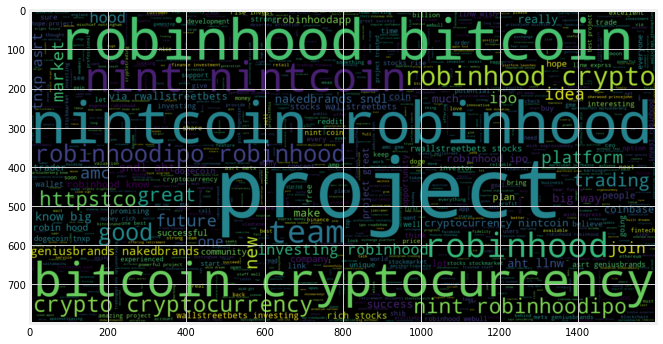

In [92]:
# Plot the word cloud for text with positive sentiment
plt.figure(figsize = (10, 10)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(Hood_df[Hood_df['Sentiment'] == 1]['Tweets Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

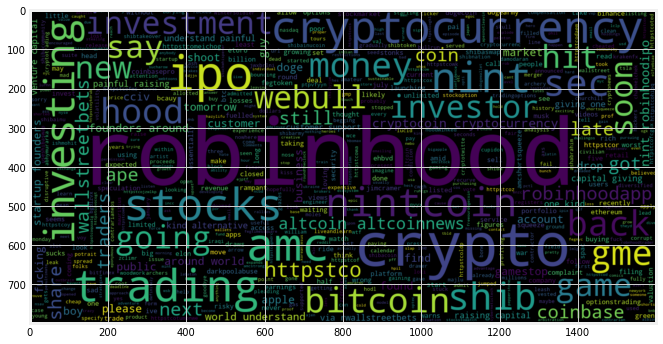

In [130]:
# Plot the word cloud for text with negative sentiment
plt.figure(figsize = (10, 10)) 
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(Hood_df[Hood_df['Sentiment'] == 0]['Tweets Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

In [131]:
# Check the shape of the DataFrame
Hood_df.shape

(554, 7)

In [132]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [133]:
# word_tokenize is used to break up a string into words
print(Hood_df['Tweets Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(Hood_df['Tweets Without Punc & Stopwords Joined'][0]))

robinhood markets inc considering launching retirement accounts ceo cofounder vladtenev confirmed webcast robinhood unitedstates robinhoodapp
['robinhood', 'markets', 'inc', 'considering', 'launching', 'retirement', 'accounts', 'ceo', 'cofounder', 'vladtenev', 'confirmed', 'webcast', 'robinhood', 'unitedstates', 'robinhoodapp']


In [134]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in Hood_df['Tweets Without Punc & Stopwords Joined'] ]
tweets_length

[15,
 18,
 21,
 15,
 17,
 19,
 18,
 19,
 20,
 12,
 25,
 27,
 18,
 28,
 16,
 26,
 12,
 13,
 29,
 18,
 24,
 17,
 13,
 25,
 21,
 17,
 21,
 6,
 22,
 23,
 23,
 20,
 24,
 11,
 24,
 21,
 24,
 12,
 12,
 9,
 11,
 26,
 23,
 24,
 25,
 24,
 21,
 21,
 27,
 16,
 13,
 15,
 24,
 9,
 21,
 16,
 20,
 5,
 17,
 23,
 14,
 9,
 18,
 12,
 19,
 22,
 17,
 17,
 22,
 21,
 17,
 15,
 24,
 15,
 22,
 24,
 15,
 20,
 13,
 25,
 24,
 22,
 21,
 14,
 21,
 14,
 10,
 6,
 21,
 12,
 14,
 17,
 22,
 19,
 16,
 19,
 23,
 27,
 6,
 13,
 8,
 24,
 11,
 10,
 4,
 16,
 18,
 21,
 26,
 21,
 11,
 15,
 8,
 19,
 19,
 10,
 20,
 8,
 26,
 21,
 11,
 20,
 20,
 16,
 5,
 9,
 6,
 5,
 13,
 30,
 5,
 13,
 15,
 9,
 26,
 11,
 19,
 16,
 15,
 17,
 10,
 8,
 18,
 6,
 20,
 21,
 21,
 21,
 14,
 14,
 19,
 20,
 8,
 8,
 12,
 19,
 28,
 8,
 15,
 19,
 20,
 27,
 26,
 21,
 15,
 22,
 8,
 17,
 25,
 18,
 17,
 21,
 11,
 23,
 15,
 15,
 5,
 4,
 10,
 21,
 18,
 17,
 11,
 28,
 14,
 16,
 26,
 29,
 25,
 25,
 22,
 20,
 20,
 18,
 30,
 13,
 23,
 22,
 27,
 27,
 14,
 22,
 23,
 22,
 21,


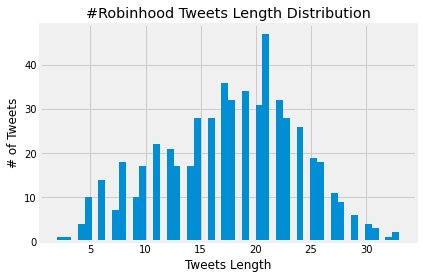

In [250]:
# Plot the Tweets length distribution
plt.hist(tweets_length, bins=50)
plt.title('#Robinhood Tweets Length Distribution')
plt.xlabel('Tweets Length')
plt.ylabel('# of Tweets')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


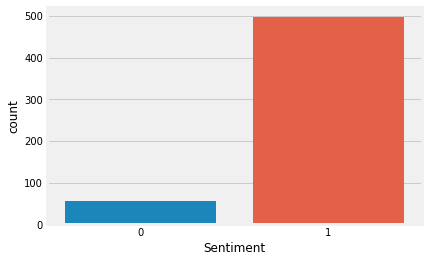

In [136]:
# Count plot for sentiments
sns.countplot(Hood_df['Sentiment'])

In [137]:
# Obtain the total words present in the dataset
list_of_words = []
for i in Hood_df['Tweets Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [138]:
list_of_words

['robinhood',
 'markets',
 'inc',
 'considering',
 'launching',
 'retirement',
 'accounts',
 'ceo',
 'cofounder',
 'vladtenev',
 'confirmed',
 'webcast',
 'robinhood',
 'unitedstates',
 'robinhoodapp',
 'nintcoin',
 'proud',
 'nintcoin',
 'company',
 'hopefully',
 'project',
 'successful',
 'advance',
 'rapidly',
 'growing',
 'fore',
 'company',
 'progress',
 'nint',
 'nintcoin',
 'robinhood',
 'bitcoin',
 'cryptocurrency',
 'nintcoin',
 'nint',
 'robinhoodipo',
 'robinhood',
 'crypto',
 'cryptocurrency',
 'good',
 'project',
 'interesting',
 'informative',
 'knowledge',
 'team',
 'behind',
 'project',
 'well',
 'experienced',
 'hope',
 'longer',
 'proper',
 'goalsnice',
 'project',
 'robinhoods',
 'revealed',
 'revenue',
 'came',
 'crypto',
 'currency',
 'transactions',
 'dogecoin',
 'made',
 'cryptotrading',
 'revenue',
 'total',
 'revenue',
 'httpstcou',
 'cxhpi',
 'robinhood',
 'kindly',
 'request',
 'robinhood',
 'list',
 'saitama',
 'inu',
 'coin',
 'sign',
 'petition',
 'httpstc

In [139]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

2977

In [165]:
# split the data into test and train 
X = Hood_df['Tweets Without Punc & Stopwords']
y = Hood_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [166]:
X_train.shape

(498,)

In [167]:
X_test.shape

(56,)

In [168]:
X_train

101    [dogecoinrich, robinhoodapp, plan, spending, s...
392    [real, amazing, project, super, latest, techno...
236    [team, professionals, constantly, working, dev...
404    [robinhood, set, public, ipo, next, business, ...
514    [ctreet, stabilize, nint, coin, usd, per, coin...
                             ...                        
131    [robinhood, iporoadshow, keeps, failing, hmmm,...
2      [nintcoin, nint, robinhoodipo, robinhood, cryp...
250    [nintcoin, project, deserves, attention, ideas...
348    [investor, alert, labaton, sucharow, pursuing,...
271    [one, real, estate, investments, headquartered...
Name: Tweets Without Punc & Stopwords, Length: 498, dtype: object

In [169]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)


In [170]:
train_sequences

[[969,
  44,
  407,
  589,
  970,
  7,
  1,
  971,
  972,
  973,
  408,
  29,
  54,
  40,
  172,
  118,
  590,
  974,
  975,
  976,
  307,
  155,
  308,
  591],
 [173,
  76,
  2,
  409,
  309,
  245,
  310,
  76,
  2,
  131,
  977,
  978,
  29,
  410,
  979,
  156,
  5,
  3,
  1,
  6,
  4],
 [9, 592, 593, 110, 157, 20, 594, 2, 132, 99, 61, 100, 5, 3, 1, 6, 4],
 [1,
  174,
  175,
  12,
  101,
  158,
  980,
  981,
  246,
  311,
  982,
  595,
  596,
  102,
  176,
  983,
  17],
 [984,
  985,
  5,
  71,
  595,
  247,
  71,
  986,
  987,
  988,
  989,
  312,
  4,
  133,
  20,
  313,
  54,
  62,
  7,
  248,
  119,
  314,
  22,
  159,
  315,
  5,
  3,
  1,
  6],
 [5,
  177,
  160,
  249,
  88,
  131,
  597,
  63,
  77,
  199,
  78,
  77,
  316,
  411,
  78,
  412,
  5,
  3,
  1,
  6,
  4,
  990,
  991],
 [1,
  992,
  993,
  994,
  175,
  598,
  995,
  996,
  1,
  89,
  134,
  45,
  599,
  120,
  78,
  135,
  600,
  317,
  178,
  1,
  12],
 [5,
  3,
  1,
  6,
  4,
  2,
  66,
  57,
  601,
  602,

In [171]:
test_sequences

[[203, 1, 1236, 625, 21, 193],
 [39,
  77,
  943,
  2413,
  156,
  39,
  186,
  2414,
  182,
  262,
  144,
  294,
  1,
  55,
  208,
  6,
  2415,
  95,
  24],
 [944,
  1558,
  24,
  1,
  212,
  213,
  184,
  134,
  2183,
  77,
  172,
  431,
  122,
  28,
  77,
  1510,
  260,
  1789,
  1231],
 [224, 1, 12, 12, 13, 8, 329, 16],
 [70,
  180,
  80,
  417,
  235,
  73,
  1427,
  301,
  2043,
  2459,
  571,
  186,
  41,
  55,
  1471,
  1756,
  2415,
  7,
  1],
 [1137,
  1,
  1138,
  360,
  1139,
  1140,
  1141,
  175,
  1142,
  23,
  680,
  681,
  23,
  1143,
  118,
  1144,
  12,
  1,
  54,
  81,
  25,
  470,
  42,
  1145,
  7,
  18],
 [378,
  2483,
  64,
  288,
  2441,
  376,
  817,
  318,
  1795,
  1,
  32,
  14,
  195,
  257,
  1521,
  55,
  39,
  185],
 [9, 126, 89, 751, 2, 2495, 123, 35, 26, 423, 5, 3, 1, 6, 4],
 [106, 94, 20, 894, 20, 232, 831, 64, 7, 405, 199, 5, 3, 1, 6, 4],
 [1, 1081, 2116, 26, 2116, 1874, 421, 848, 693, 499],
 [1151, 155, 895, 1152, 2062, 1555, 15, 12, 242, 919, 1],


In [172]:
print("The encoding for document\n", X_train[1:2],"\n is: ", train_sequences[1])

The encoding for document
 392    [real, amazing, project, super, latest, techno...
Name: Tweets Without Punc & Stopwords, dtype: object 
 is:  [173, 76, 2, 409, 309, 245, 310, 76, 2, 131, 977, 978, 29, 410, 979, 156, 5, 3, 1, 6, 4]


In [173]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [174]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [969  44 407 589 970   7   1 971 972 973 408  29  54  40 172]
The padded encoding for document: 2  is: [173  76   2 409 309 245 310  76   2 131 977 978  29 410 979]
The padded encoding for document: 3  is: [  9 592 593 110 157  20 594   2 132  99  61 100   5   3   1]


In [175]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

In [176]:
y_train_cat.shape

(498, 2)

In [177]:
y_test_cat.shape

(56, 2)

In [178]:
y_train_cat

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [236]:
# Sequential Model
model = Sequential()

# embedding layer
model.add(Embedding(total_words, output_dim = 512))

# Bi-Directional RNN and LSTM
model.add(LSTM(256))

# Dense layers
model.add(Dense(900, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 512)         1524224   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_16 (Dense)             (None, 900)               231300    
_________________________________________________________________
dropout_8 (Dropout)          (None, 900)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 1802      
Total params: 2,544,782
Trainable params: 2,544,782
Non-trainable params: 0
_________________________________________________________________


In [237]:
# Train the model
model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.1, epochs = 9)

Epoch 1/9
14/14 [==============================] - 4s 177ms/step - loss: 0.4744 - acc: 0.8571 - val_loss: 0.2873 - val_acc: 0.9000
Epoch 2/9
14/14 [==============================] - 2s 139ms/step - loss: 0.2027 - acc: 0.9107 - val_loss: 0.3844 - val_acc: 0.9000
Epoch 3/9
14/14 [==============================] - 2s 139ms/step - loss: 0.0477 - acc: 0.9911 - val_loss: 1.1897 - val_acc: 0.7800
Epoch 4/9
14/14 [==============================] - 2s 137ms/step - loss: 0.0224 - acc: 0.9933 - val_loss: 0.4551 - val_acc: 0.9000
Epoch 5/9
14/14 [==============================] - 2s 143ms/step - loss: 0.0089 - acc: 0.9955 - val_loss: 0.7348 - val_acc: 0.8800
Epoch 6/9
14/14 [==============================] - 2s 143ms/step - loss: 5.4009e-05 - acc: 1.0000 - val_loss: 0.8694 - val_acc: 0.8600
Epoch 7/9
14/14 [==============================] - 2s 142ms/step - loss: 2.6092e-05 - acc: 1.0000 - val_loss: 0.9125 - val_acc: 0.8600
Epoch 8/9
14/14 [==============================] - 2s 145ms/step - loss: 1.

In [238]:
# Make prediction
pred = model.predict(padded_test)

In [239]:
pred

array([[1.1205578e-03, 9.9887949e-01],
       [3.0416111e-06, 9.9999690e-01],
       [2.2777516e-04, 9.9977225e-01],
       [1.9481512e-03, 9.9805188e-01],
       [7.4206860e-06, 9.9999261e-01],
       [1.0000000e+00, 5.6774835e-10],
       [9.0302252e-05, 9.9990964e-01],
       [1.2634548e-06, 9.9999869e-01],
       [5.2344836e-05, 9.9994767e-01],
       [4.6747108e-03, 9.9532533e-01],
       [7.5812600e-06, 9.9999237e-01],
       [1.1398785e-02, 9.8860127e-01],
       [4.4145402e-02, 9.5585465e-01],
       [2.2540161e-01, 7.7459842e-01],
       [3.3042081e-05, 9.9996698e-01],
       [1.7855925e-07, 9.9999988e-01],
       [1.7101294e-04, 9.9982893e-01],
       [3.7599955e-02, 9.6240008e-01],
       [3.0106771e-06, 9.9999702e-01],
       [3.3657150e-03, 9.9663430e-01],
       [6.7705923e-07, 9.9999928e-01],
       [5.8834707e-06, 9.9999416e-01],
       [1.9699475e-05, 9.9998033e-01],
       [2.3818443e-07, 9.9999976e-01],
       [2.5991267e-06, 9.9999738e-01],
       [1.9617929e-04, 9.

In [240]:
# Make prediction
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [241]:
prediction

[1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [242]:
# List containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [243]:
original

[0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [244]:
# Acuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.9464285714285714

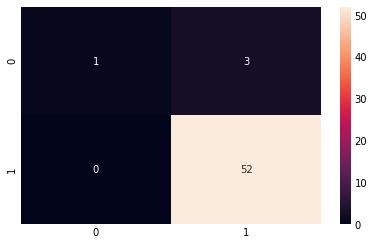

In [245]:
# Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)